array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e85b2e8>]], dtype=object)

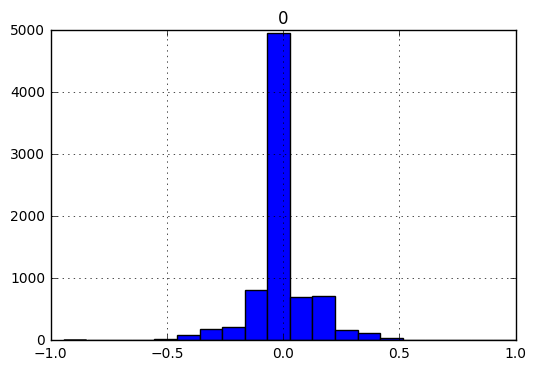

In [24]:
%matplotlib inline

import matplotlib as plt
import numpy as np
 
import cv2
import json
import pandas


with open('driving_log.csv') as csvfile:
    reader = pandas.read_csv(csvfile)
    #for line in reader:
    #    samples.append(line)

reader.iloc[:,3:4].hist(bins=20)

#reader.round(1).groupby(['steering']).count().plot(kind='bar')
#data['steering'].head().round(1).count().plot()
  



In [35]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, ELU
from keras.activations import relu, softmax
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.regularizers import l2
import math
import os
import json
import csv

def generator(samples, batch_size=128):
    num_samples = len(samples)
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        
        for offset in range(0, num_samples, batch_size):
            
            batch_samples = samples[offset:offset+batch_size]
            images = []
            measurements = []

            
            for batch_sample in batch_samples:
                
                # Append left and right cameras to the originial images
                for i in range(3):
                    path = batch_sample[i]
                    tokens = path.split('/')
                    filename = tokens[-1]
                    local_path = 'IMG/'+filename
                    image = cv2.imread(local_path)
                    images.append(image)
                    
                # Append left and right angles with correction(+-0.2)    
                correction = .2
                measurement = float(batch_sample[3])
                measurements.append(measurement)
                measurements.append(measurement+correction)
                measurements.append(measurement-correction)

                aug_imgs = []
                aug_msmt = []

                # Append flipped images to the samples
                for image, measurement in zip(images, measurements):
                    
                    if abs(measurement) <= 0.01:
                        to_add = np.random.randint(0,20)
                        if to_add == 1:
                            aug_imgs.append(image)
                            aug_msmt.append(measurement) 
                            
                            flipped_image = cv2.flip(image, 1)
                            flipped_msmt = measurement * -1.0
                            
                            aug_imgs.append(flipped_image)
                            aug_msmt.append(flipped_msmt) 

                    else:
                        aug_imgs.append(image)
                        aug_msmt.append(measurement)

                        flipped_image = cv2.flip(image, 1)
                        flipped_msmt = measurement * -1.0


                        aug_imgs.append(flipped_image)
                        aug_msmt.append(flipped_msmt) 
                        

            X_sample = np.array(aug_imgs)
            y_sample = np.array(aug_msmt)
                
            yield shuffle(X_sample, y_sample)


def get_model(time_len=1):
    """
    A slightly modified version of the Nvidia model
    """
    model = Sequential()
    model.add(Lambda(lambda x: x/255 - 0.5,input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70,25),(0,0))))
    model.add(Convolution2D(24, 5, 5, subsample=(2,2),activation='relu'))
    model.add(Convolution2D(36, 5, 5,subsample=(2,2), activation='relu'))
    model.add(Convolution2D(48, 5, 5,subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model



samples = []
with open('driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)


train_samples, validation_samples = train_test_split(samples, test_size=0.2)
#X_train, X_validation, y_train, y_validation = train_test_split(X_sample, y_sample, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)


model = get_model()
model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator,
                    nb_val_samples=len(validation_samples), nb_epoch=3)
model.save("model.h5")
print("Saving model weights and configuration file.")






Epoch 1/3
6316/6428 [============================>.] - ETA: 2s - loss: 0.0345 - acc: 0.0114

/Users/ying/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6474/6428 [==============================] - 133s - loss: 0.0348 - acc: 0.0111 - val_loss: 0.0208 - val_acc: 0.0093
Epoch 2/3
6470/6428 [==============================] - 122s - loss: 0.0210 - acc: 0.0121 - val_loss: 0.0224 - val_acc: 0.0058
Epoch 3/3
6452/6428 [==============================] - 122s - loss: 0.0213 - acc: 0.0108 - val_loss: 0.0202 - val_acc: 0.0123
Saving model weights and configuration file.
